#### Netflix Data EDA 

In [1]:
import numpy as np
import pandas as pd
import wordcloud as wc

import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ipywidgets
import squarify
import networkx as nx

from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_netflix = pd.read_csv('netflix_titles.csv')
display(df_netflix.shape)
df_netflix.head(3)

(6234, 12)

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...

#### Preprocessing

In [3]:
df_netflix["date_added"] = pd.to_datetime(df_netflix['date_added'])
df_netflix['year_added'] = df_netflix['date_added'].dt.year
df_netflix['month_added'] = df_netflix['date_added'].dt.month
df_netflix['Genres'] = df_netflix['listed_in'].str.extract('([A-Z]\w{2,})', expand=True)

In [4]:
df_netflix['season_count'] = df_netflix.apply(lambda x : x['duration'].split(" ")[0] 
                                              if "Season" in x['duration'] else "", axis = 1)
df_netflix['duration'] = df_netflix.apply(lambda x : x['duration'].split(" ")[0] 
                                          if "Season" not in x['duration'] else "", axis = 1)

In [5]:
display(df_netflix.shape)
df_netflix.head(3)

(6234, 16)

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   

                                    country date_added  release_year  \
0  United States, India, South Korea, China 2019-09-09          2019   
1                            United Kingdom 2016-09-09          2016   
2                             United States 2018-09-08          2013   

     rating duration                           listed_in  \
0     TV-PG       90  Children & Family Movies, Comedies   
1     TV-MA       94                     Stand-Up Comedy   
2  TV-Y7-FV                                     Kids' TV   

                                         description  year_added  month_added  \
0  Before planning an awesome wedding for his gra...      2019.0          9.0   
1  Jandino Asporaat riffs on the challenges of ra...      2016.0          9.0   
2  With the help of three human allies, the Autob...      2018.0          9.0   

     Genres season_count  
0  Children               
1     Stand               
2      Kids            1

#### Deal with missing values

In [6]:
df_netflix.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
year_added        11
month_added       11
Genres             0
season_count       0
dtype: int64

In [7]:
cols = ['director', 'cast', 'country', 'date_added', 'rating']
df_netflix[cols] = df_netflix[cols].fillna(value='')
cols = ['year_added', 'month_added']
df_netflix[cols] = df_netflix[cols].fillna(value=0)
df_netflix.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
Genres          0
season_count    0
dtype: int64

In [8]:
df_netflix['season_count'] = df_netflix['season_count'].replace('', 0).astype(int)

### EDA
---
#### Title Keywords

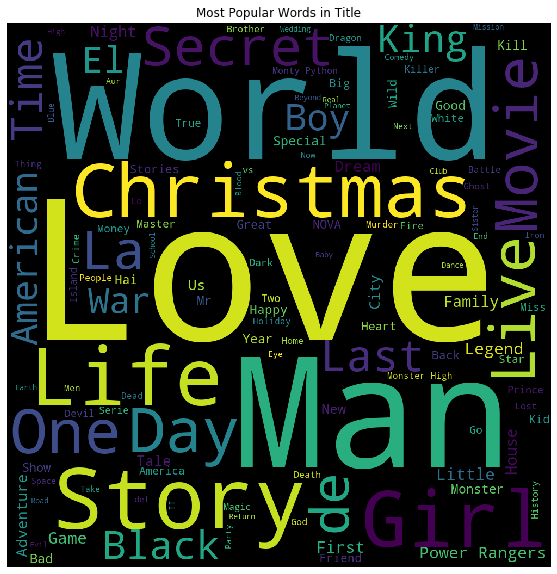

In [9]:
plt.figure(figsize=(10,10))
wordcloud = wc.WordCloud(stopwords=wc.STOPWORDS,
                         background_color = 'black', width = 1000,  
                         height = 1000, max_words = 121).generate(' '.join(df_netflix['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words in Title',fontsize = 12)
plt.show()

#### MOVIES AND TV SHOWS

In [10]:
labels=df_netflix['type'].value_counts().index
values=df_netflix['type'].value_counts().values

trace = go.Pie(labels=labels, 
               values=values, 
               title='Content Type', 
               hoverinfo='percent+value', 
               textinfo='percent',
               textposition='inside',
               hole=0.6,
               showlegend=True,
               marker=dict(colors=['lightpurple', 'lightred'],
                           line=dict(color='#000000',width=2)),
               textfont_size=20,

              )

fig = go.Figure(data=[trace])
fig.show()

In [11]:
df_TV = df_netflix[df_netflix["type"] == "TV Show"]
df_Movie = df_netflix[df_netflix["type"] == "Movie"]

In [12]:
col = "year_added"
vc_tv = df_TV[col].value_counts().reset_index()
vc_tv = vc_tv.rename(columns = {col : "count", "index" : col})
vc_tv['percent'] = vc_tv['count'].apply(lambda x : 100*x/sum(vc_tv['count']))
vc_tv = vc_tv.sort_values(col)

vc_mov = df_Movie[col].value_counts().reset_index()
vc_mov = vc_mov.rename(columns = {col : "count", "index" : col})
vc_mov['percent'] = vc_mov['count'].apply(lambda x : 100*x/sum(vc_mov['count']))
vc_mov = vc_mov.sort_values(col)

In [13]:
traceTV = go.Scatter(
                    x=vc_tv[col], 
                    y=vc_tv["count"], 
                    name="TV Shows", 
                    marker=dict(color = 'rgb(249, 6, 6)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))

traceMOV = go.Scatter(
                    x=vc_mov[col], 
                    y=vc_mov["count"], 
                    name="Movies", 
                    marker= dict(color = 'rgb(26, 118, 255)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))

layout = go.Layout(hovermode= 'closest', title = 'Content added over the years', 
                   xaxis = dict(title = 'Year'), yaxis = dict(title = 'Count'), template= "plotly_dark")
fig = go.Figure(data = [traceTV, traceMOV], layout=layout)
fig.show()

 ###### The data shows Netflix purchasing and inversting more in movies licenses for the customers.

#### RATING & CONTENT TYPE

In [14]:
labels=df_netflix['rating'].value_counts().index
values=df_netflix['rating'].value_counts().values

trace = go.Pie(labels=labels, 
               values=values, 
               title='Rating', 
               hoverinfo='percent+value', 
               textinfo='percent',
               textposition='inside',
               hole=0.6,
               showlegend=True,
               marker=dict(colors=plt.cm.viridis_r(np.linspace(0, 1, 14)),
                           line=dict(color='#000000',
                                     width=2),
                          ),
               textfont_size=20
              )

fig = go.Figure(data=[trace])
fig.show()

In [15]:
vcTV = df_TV['rating'].value_counts().reset_index()
vcMOV = df_Movie['rating'].value_counts().reset_index()

In [16]:
traceTV = go.Bar(
                x = vcTV['index'],
                y = vcTV['rating'],
                name="TV Shows",
                marker = dict(color = 'rgb(249, 6, 6)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))

traceMOV = go.Bar(
                x = vcMOV['index'],
                y = vcMOV['rating'],
                name = "Movies",
                marker = dict(color = 'rgb(26, 118, 255)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))

layout = go.Layout(template= "plotly_dark",
                   title = 'RATING BY CONTENT TYPE',
                   xaxis = dict(title = 'Rating'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data = [traceTV, traceMOV], layout = layout)
fig.show()

MOST POPULAR GENRES ON NETFILX


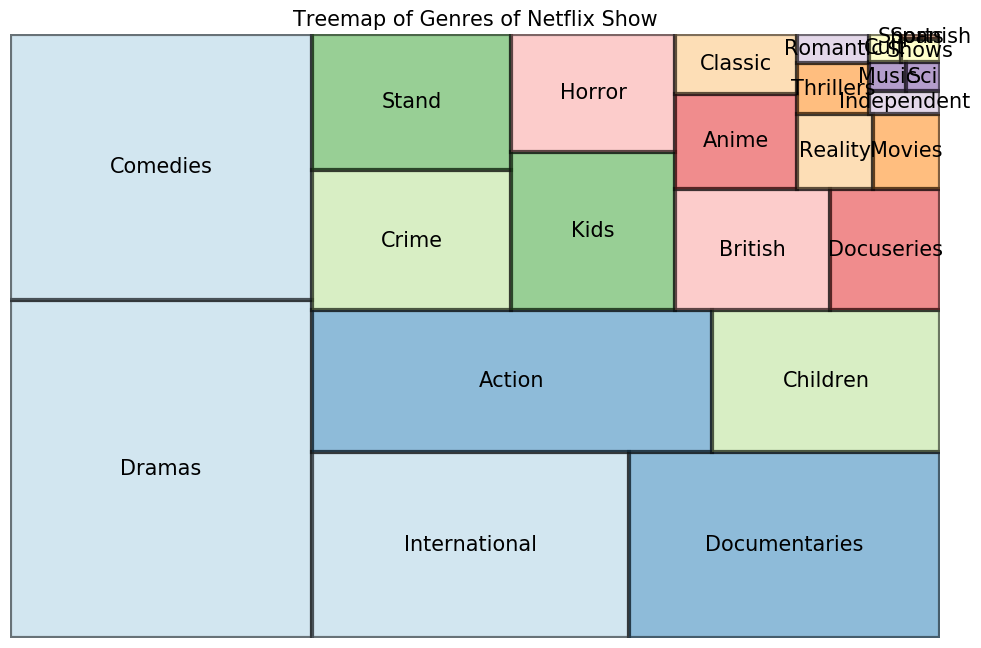

In [17]:
print('MOST POPULAR GENRES ON NETFILX')
vcGnr = df_netflix['Genres'].value_counts().reset_index()

sizes=np.array(vcGnr['Genres'])
labels=vcGnr['index']

_len = float(len(labels));
colors = [plt.cm.Paired(i/_len) for i in range(len(labels))]

plt.figure(figsize=(12,8), dpi= 100)
squarify.plot(sizes=sizes, label=labels, color = colors, alpha=.5, edgecolor="black", linewidth=3, text_kwargs={'fontsize':15})
plt.title('Treemap of Genres of Netflix Show', fontsize = 15)
plt.axis('off')
plt.show()

#### CORRELATION WITHIN THE CATEGORIES

In [18]:
data= df_netflix['listed_in'].astype(str).apply(lambda s : s.replace('&',' ').replace(',', ' ').split()) 
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(data), columns=mlb.classes_)
corr = res.corr()

In [19]:
def create_corr_network(Graph, corr_direction, min_correlation):
    H = Graph.copy()
    for stock1, stock2, weight in Graph.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)
    
    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, edge_list=edges,style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 

In [20]:
values = corr.index.values
corr_matrix = np.asmatrix(corr)

Graph = nx.from_numpy_matrix(corr_matrix)
Graph = nx.relabel_nodes(Graph,lambda x: values[x])
Graph.edges(data=True)
display()

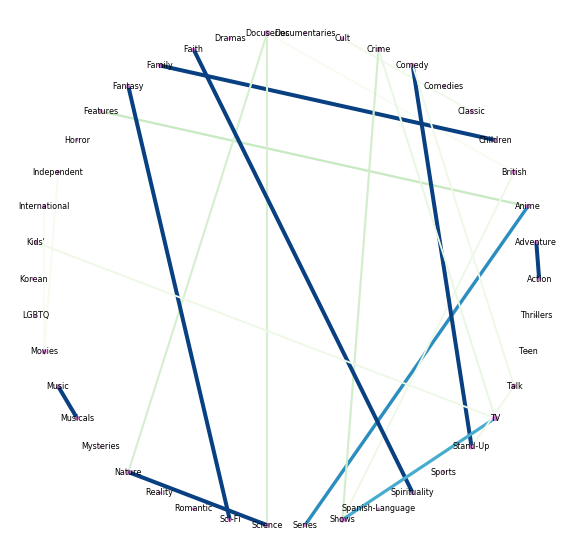

In [21]:
create_corr_network(Graph, 'positive', 0.3)

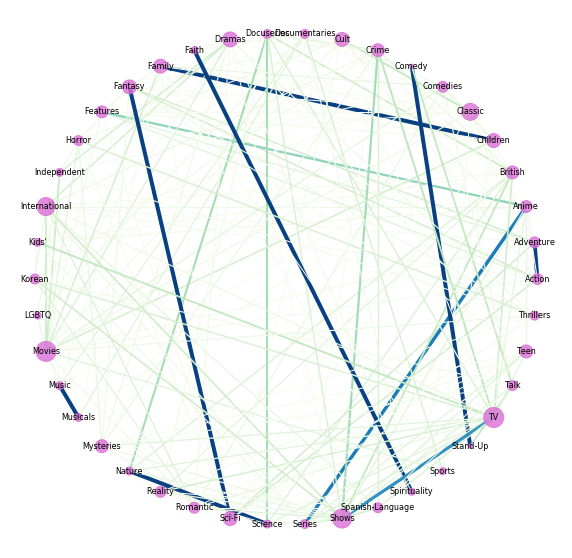

In [22]:
create_corr_network(Graph, 'positive', -0.3)

#### RELEASE YEAR, DURATION, SEASON

In [23]:
vc_year = df_netflix['release_year'].value_counts().reset_index()

traceYear = go.Bar(
                x = vc_year['index'],
                y = vc_year['release_year'],
                marker = dict(color = 'rgb(255,165,0)',
                             line=dict(color='rgb(0,0,0)',width=1.5)))

layout = go.Layout(template= "plotly_dark",title = 'CONTENT RELEASE OVER THE YEAR', 
                   xaxis = dict(title = 'Year'), yaxis = dict(title = 'Count'))

fig = go.Figure(data = [traceYear], layout = layout)
fig.show()

In [24]:
vcTV_year = df_TV['release_year'].value_counts().reset_index()
vcMOV_year = df_Movie['release_year'].value_counts().reset_index()


traceTV_year = go.Bar(x = vcTV_year['index'],
                y = vcTV_year['release_year'],
                name="TV Shows",
                marker = dict(color = 'rgb(249, 6, 6)'))

traceMOV_year = go.Bar(x = vcMOV_year['index'],
                y = vcMOV_year['release_year'],
                name = "Movies",
                marker = dict(color = 'rgb(26, 118, 255)'))


layout = go.Layout(template= "plotly_dark",title = 'CONTENT RELEASE OVER THE YEAR BY CONTENT TYPE', 
                   xaxis = dict(title = 'Year'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [traceTV_year, traceMOV_year], layout = layout)
fig.show()

In [25]:
traceDur = go.Histogram(x = df_netflix['duration'],
                     xbins=dict(size=0.5),
                     marker = dict(color = 'rgb(26, 118, 255)'))
layout = go.Layout(template= "plotly_dark", title = 'Distribution of Movies Duration', 
                   xaxis = dict(title = 'Minutes'))
fig = go.Figure(data = [traceDur], layout = layout)
fig.show()

In [26]:
traceSeasn = go.Histogram(x = df_netflix['season_count'],
                     marker = dict(color = 'rgb(249, 6, 6)'))
layout = go.Layout(template= "plotly_dark", title = 'Seasons of TV Shows', xaxis = dict(title = 'No. of Seasons'))
fig = go.Figure(data = [traceSeasn], layout = layout)
fig.show()

In [27]:
hghst_seasn = df_netflix['season_count'].max()
display(df_netflix[df_netflix['season_count'] == hghst_seasn])

show_id     type           title director  \
5908  70140391  TV Show  Grey's Anatomy            
5974  70142386  TV Show            NCIS            

                                                   cast        country  \
5908  Ellen Pompeo, Sandra Oh, Katherine Heigl, Just...  United States   
5974  Mark Harmon, Michael Weatherly, Pauley Perrett...  United States   

               date_added  release_year rating duration  \
5908  2019-06-15 00:00:00          2018  TV-14            
5974  2018-07-01 00:00:00          2017  TV-14            

                                    listed_in  \
5908             Romantic TV Shows, TV Dramas   
5974  Crime TV Shows, TV Dramas, TV Mysteries   

                                            description  year_added  \
5908  Intern (and eventual resident) Meredith Grey f...      2019.0   
5974  Follow the quirky agents of the NCIS – the Nav...      2018.0   

      month_added    Genres  season_count  
5908          6.0  Romantic            15  
5974          7.0     Crime            15

In [28]:
print('OLDEST MOVIES ON NETFLIX')
oldest = df_netflix.sort_values("release_year", ascending = True)
oldest = oldest[oldest['duration'] != ""]
display(oldest[['title', "release_year", 'listed_in','country']][:10])

OLDEST MOVIES ON NETFLIX


title  release_year  \
2011                                    Prelude to War          1942   
2013                              The Battle of Midway          1942   
2022     Undercover: How to Operate Behind Enemy Lines          1943   
2023                Why We Fight: The Battle of Russia          1943   
2026                   WWII: Report from the Aleutians          1943   
2017  The Memphis Belle: A Story of a\nFlying Fortress          1944   
2019                                 The Negro Soldier          1944   
2021                                  Tunisian Victory          1944   
2012                                        San Pietro          1945   
2009                          Nazi Concentration Camps          1945   

                          listed_in                        country  
2011  Classic Movies, Documentaries                  United States  
2013  Classic Movies, Documentaries                  United States  
2022  Classic Movies, Documentaries                  United States  
2023                  Documentaries                  United States  
2026                  Documentaries                  United States  
2017  Classic Movies, Documentaries                  United States  
2019  Classic Movies, Documentaries                  United States  
2021  Classic Movies, Documentaries  United States, United Kingdom  
2012  Classic Movies, Documentaries                  United States  
2009  Classic Movies, Documentaries                  United States

In [29]:
print('OLDEST TV SHOW ON NETFLIX')
oldest = df_netflix.sort_values("release_year", ascending = True)
oldest = oldest[oldest['season_count'] != ""]
display(oldest[['title', "release_year", 'listed_in','country']][:10])

OLDEST TV SHOW ON NETFLIX


title  release_year  \
4292                 Pioneers: First Women Filmmakers*          1925   
2011                                    Prelude to War          1942   
2013                              The Battle of Midway          1942   
2022     Undercover: How to Operate Behind Enemy Lines          1943   
2023                Why We Fight: The Battle of Russia          1943   
2026                   WWII: Report from the Aleutians          1943   
2017  The Memphis Belle: A Story of a\nFlying Fortress          1944   
2019                                 The Negro Soldier          1944   
2021                                  Tunisian Victory          1944   
2012                                        San Pietro          1945   

                          listed_in                        country  
4292                       TV Shows                                 
2011  Classic Movies, Documentaries                  United States  
2013  Classic Movies, Documentaries                  United States  
2022  Classic Movies, Documentaries                  United States  
2023                  Documentaries                  United States  
2026                  Documentaries                  United States  
2017  Classic Movies, Documentaries                  United States  
2019  Classic Movies, Documentaries                  United States  
2021  Classic Movies, Documentaries  United States, United Kingdom  
2012  Classic Movies, Documentaries                  United States

#### COUNTRY, CAST, DIRECTOR

In [30]:
vcCountry = df_netflix['country'].value_counts().reset_index()[:20]

traceCountry = go.Bar(
                x = vcCountry['index'],
                y = vcCountry['country'],
                marker = dict(color = 'rgb(153,255,153)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(template= "plotly_dark",title = 'TOP 20 COUNTIES WITH MOST CONTENT' , xaxis = dict(title = 'Countries'), yaxis = dict(title = 'Count'))
fig = go.Figure(data = [traceCountry], layout = layout)
fig.show()

In [31]:
countries = ['United States', 'India', '', 'Taiwan']
colors = ['crimson', 'indigo', 'deepskyblue', 'springgreen']

fig = make_subplots(rows=2, cols=2,subplot_titles=("United States", "India", "", "Taiwan"))
idx = 0

for country in countries:
    temp_df = df_netflix[df_netflix['type']=='Movie']
    temp_df = temp_df[temp_df['country']==country]

    categories = ", ".join(temp_df['director'].fillna("")).split(", ")
    counter_list = Counter(categories).most_common(11)
    counter_list = [_ for _ in counter_list if _[0] != ""]
    labels = [_[0] for _ in counter_list][::-1]
    values = [_[1] for _ in counter_list][::-1]
    trace1 = go.Bar(x = labels,
                    y = values,
                    marker = dict(color = colors[idx],
                                  line=dict(color=colors[idx], width=1.5))
                   )
    
    
    fig.append_trace(trace1, int(idx / 2) + 1, idx % 2 + 1)
    idx += 1
    
fig.update_layout(height=800, width=950,template= "plotly_dark",title_text = 'TOP 10 MOVIES DIRECTORS MOST CONTENT')
fig.show()

In [32]:
countries = ['United States', 'India', '', 'Taiwan']
colors = ['crimson', 'indigo', 'deepskyblue', 'springgreen']

fig = make_subplots(rows=2, cols=2,subplot_titles=("United States", "India", "", "Taiwan"))
idx = 0

for country in countries:
    temp_df = df_netflix[df_netflix['type']=='Movie']
    temp_df = temp_df[temp_df['country']==country]

    categories = ", ".join(temp_df['cast'].fillna("")).split(", ")
    counter_list = Counter(categories).most_common(11)
    counter_list = [_ for _ in counter_list if _[0] != ""]
    labels = [_[0] for _ in counter_list][::-1]
    values = [_[1] for _ in counter_list][::-1]
    trace1 = go.Bar(x = labels,
                    y = values,
                    marker = dict(color = colors[idx],
                                  line=dict(color=colors[idx],width=1.5))
                   )
    
    
    fig.append_trace(trace1, int(idx / 2) + 1, idx % 2 + 1)
    idx += 1
    
fig.update_layout(height=800, width=950,template= "plotly_dark",title_text = 'TOP 10 MOVIES ACTORS MOST CONTENT')
fig.show()

In [33]:
countries = ['United States', 'India', '', 'Taiwan']
colors = ['crimson', 'indigo', 'deepskyblue', 'springgreen']

fig = make_subplots(rows=2, cols=2,subplot_titles=("United States", "India", "", "Taiwan"))
idx = 0

for country in countries:
    temp_df = df_netflix[df_netflix['type']=='TV Show']
    temp_df = temp_df[temp_df['country']==country]

    categories = ", ".join(temp_df['director'].fillna("")).split(", ")
    counter_list = Counter(categories).most_common(11)
    counter_list = [_ for _ in counter_list if _[0] != ""]
    labels = [_[0] for _ in counter_list][::-1]
    values = [_[1] for _ in counter_list][::-1]
    trace1 = go.Bar(x = labels,
                    y = values,
                    marker = dict(color = colors[idx],
                                  line=dict(color=colors[idx],width=1.5))
                   )
    
    
    fig.append_trace(trace1, int(idx / 2) + 1, idx % 2 + 1)
    idx += 1
    
fig.update_layout(height=800, width=950,template= "plotly_dark",title_text = 'TOP 10 TV SHOW DIRECTORS MOST CONTENT')
fig.show()

In [34]:
countries = ['United States', 'India', '', 'Taiwan']
colors = ['crimson', 'indigo', 'deepskyblue', 'springgreen']

fig = make_subplots(rows=2, cols=2,subplot_titles=("United States", "India", "", "Taiwan"))
idx = 0

for country in countries:
    temp_df = df_netflix[df_netflix['type']=='TV Show']
    temp_df = temp_df[temp_df['country']==country]

    categories = ", ".join(temp_df['cast'].fillna("")).split(", ")
    counter_list = Counter(categories).most_common(11)
    counter_list = [_ for _ in counter_list if _[0] != ""]
    labels = [_[0] for _ in counter_list][::-1]
    values = [_[1] for _ in counter_list][::-1]
    trace1 = go.Bar(x = labels,
                    y = values,
                    marker = dict(color = colors[idx],
                                  line=dict(color=colors[idx],width=1.5))
                   )
    
    
    fig.append_trace(trace1, int(idx / 2) + 1, idx % 2 + 1)
    idx += 1
    
fig.update_layout(height=800, width=950,template= "plotly_dark",title_text = 'TOP 10 TV SHOW DIRECTORS MOST CONTENT')
fig.show()

#### Content-Based Movie Recommender System

In [35]:
df_recommend = df_netflix[['title','director','cast','listed_in','description']]
df_recommend.head()

title                  director  \
0  Norm of the North: King Sized Adventure  Richard Finn, Tim Maltby   
1               Jandino: Whatever it Takes                             
2                       Transformers Prime                             
3         Transformers: Robots in Disguise                             
4                             #realityhigh          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                            listed_in  \
0  Children & Family Movies, Comedies   
1                     Stand-Up Comedy   
2                            Kids' TV   
3                            Kids' TV   
4                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

#### REMOVE NaN VALUES AND EMPTY STRINGS:

In [36]:
df_recommend.dropna(inplace=True)

blanks = []  # start with an empty list

col=['title','director','cast','listed_in','description']
for i,col in df_recommend.iterrows():  # iterate over the DataFrame
    if type(col)==str:            # avoid NaN values
        if col.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list

df_recommend.drop(blanks, inplace=True)

In [37]:
# initializing the new column
df_recommend['Key_words'] = ""

for index, row in df_recommend.iterrows():
    description = row['description']
    
    # instantiating Rake, by default it uses english stopwords from NLTK
    # and discards all puntuation characters as well
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(description)

    # getting the dictionary whith key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column for the corresponding movie
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
df_recommend.drop(columns = ['description'], inplace = True)

In [38]:
# discarding the commas between the actors' full names and getting only the first three names
df_recommend['cast'] = df_recommend['cast'].map(lambda x: x.split(',')[:3])

# putting the genres in a list of words
df_recommend['listed_in'] = df_recommend['listed_in'].map(lambda x: x.lower().split(','))

df_recommend['director'] = df_recommend['director'].map(lambda x: x.split(' '))

# merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in df_recommend.iterrows():
    row['cast'] = [x.lower().replace(' ','') for x in row['cast']]
    row['director'] = ''.join(row['director']).lower()

In [39]:
df_recommend.set_index('title', inplace = True)
df_recommend.head()

director  \
title                                                            
Norm of the North: King Sized Adventure  richardfinn,timmaltby   
Jandino: Whatever it Takes                                       
Transformers Prime                                               
Transformers: Robots in Disguise                                 
#realityhigh                                   fernandolebrija   

                                                                                 cast  \
title                                                                                   
Norm of the North: King Sized Adventure       [alanmarriott, andrewtoth, briandobson]   
Jandino: Whatever it Takes                                          [jandinoasporaat]   
Transformers Prime                         [petercullen, sumaleemontano, frankwelker]   
Transformers: Robots in Disguise          [willfriedle, darrencriss, constancezimmer]   
#realityhigh                             [nestacooper, katewalsh, johnmichaelhiggins]   

                                                                     listed_in  \
title                                                                            
Norm of the North: King Sized Adventure  [children & family movies,  comedies]   
Jandino: Whatever it Takes                                   [stand-up comedy]   
Transformers Prime                                                  [kids' tv]   
Transformers: Robots in Disguise                                    [kids' tv]   
#realityhigh                                                        [comedies]   

                                                                                 Key_words  
title                                                                                       
Norm of the North: King Sized Adventure  [evil, archaeologist, first, polar, bear, king...  
Jandino: Whatever it Takes               [sex, jandino, asporaat, riffs, rousing, rendi...  
Transformers Prime                       [three, human, allies, decepticons, megatron, ...  
Transformers: Robots in Disguise         [new, autobot, force, decepticons, protect, hu...  
#realityhigh                             [interest, ex, nerdy, high, schooler, dani, fi...

In [40]:
df_recommend['bag_of_words'] = ''
columns = df_recommend.columns
for index, row in df_recommend.iterrows():
    words = ''
    for col in columns:
        if col != 'director':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
df_recommend.drop(columns = [col for col in df_recommend.columns if col!= 'bag_of_words'], inplace = True)
df_recommend.head()

bag_of_words
title                                                                                     
Norm of the North: King Sized Adventure  richardfinn,timmaltby alanmarriott andrewtoth ...
Jandino: Whatever it Takes                jandinoasporaat stand-up comedy sex jandino a...
Transformers Prime                        petercullen sumaleemontano frankwelker kids' ...
Transformers: Robots in Disguise          willfriedle darrencriss constancezimmer kids'...
#realityhigh                             fernandolebrija nestacooper katewalsh johnmich...

#### Feature Extraction and Modeling

In [41]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df_recommend['bag_of_words'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df_recommend.index)
indices[:5]

0    Norm of the North: King Sized Adventure
1                 Jandino: Whatever it Takes
2                         Transformers Prime
3           Transformers: Robots in Disguise
4                               #realityhigh
Name: title, dtype: object

In [42]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.10540926, 0.0379049 ,
        0.04003204],
       [0.        , 1.        , 0.0559017 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0559017 , 1.        , ..., 0.        , 0.1392715 ,
        0.09805807],
       ...,
       [0.10540926, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.0379049 , 0.        , 0.1392715 , ..., 0.        , 1.        ,
        0.25492496],
       [0.04003204, 0.        , 0.09805807, ..., 0.        , 0.25492496,
        1.        ]])

In [45]:
# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(Title, cosine_sim = cosine_sim):
    
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == Title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df_recommend.index)[i])
        
    return recommended_movies

In [46]:
recommendations('Rocky')

['Rocky III',
 'Rocky IV',
 'Rocky II',
 'Rocky V',
 'Abdo Mota',
 "Logan's Run",
 'Indiana Jones and the Last Crusade',
 'Don',
 'Thong Dee Fun Khao',
 'Arjun: The Warrior Prince']

In [47]:
recommendations('War Horse')

["Schindler's List",
 'Planetarium',
 'God Bless the Broken Road',
 "The Butterfly's Dream",
 'Abdo Mota',
 'My Honor Was Loyalty',
 'Mr. Church',
 'The Good Catholic',
 'The Great Raid',
 'Harry and Snowman']

In [48]:
recommendations('3 Idiots')

['Moms at War',
 'PK',
 'Amar Akbar & Tony',
 'Pahuna',
 'Acapulco La vida va',
 'Hazaaron Khwaishein Aisi',
 'Dil Chahta Hai',
 'Kai Po Che!',
 '#Selfie 69',
 'Zindagi Na Milegi Dobara']

In [49]:
recommendations('Bad Boys')

['Bad Boys II',
 'Kung Fu Yoga',
 'War on Everyone',
 'Merantau',
 'Bon Cop Bad Cop 2',
 'Wild Wild West',
 'Men in Black II',
 'Hellboy',
 'Hera Pheri',
 'The Do-Over']